In [1]:
!pip install wget
!pip install zipfile
!pip instasll pathlib

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=e0faa8e5298572a5239c292614faab9828a584ffa9f21306f0cfd29853823e68
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
ERROR: Could not find a version that satisfies the requirement zipfile (from versions: none)
ERROR: No matching distribution found for zipfile
ERROR: unknown command "instasll" - maybe you meant "install"


In [2]:
# Import statements
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AdamW, BertConfig, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import time
import datetime
from tqdm import tqdm
import os
import wget
import zipfile
from pathlib import Path

In [3]:
# A function for the calculation of accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# A function to convert times to a readable format
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [4]:
# Set device to whatever device is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU')
else:
    device = torch.device('cpu')
    print('Using CPU')

Using GPU


In [5]:
# Load our Financial Phrasebank dataset from the huggingface page
url = 'https://huggingface.co/datasets/takala/financial_phrasebank/resolve/main/data/FinancialPhraseBank-v1.0.zip?download=true'

if not os.path.exists('FinancialPhraseBank-v1.0.zip'):
    print('Downloading Financial Phrasebank dataset...')
    wget.download(url, 'FinancialPhraseBank-v1.0.zip')

# Unzip the dataset
if not os.path.exists('FinancialPhraseBank-v1.0'):
    print('Unzipping Financial Phrasebank dataset...')
    with zipfile.ZipFile('FinancialPhraseBank-v1.0.zip', 'r') as zip_ref:
        zip_ref.extractall('FinancialPhraseBank-v1.0')

Unzipping Financial Phrasebank dataset...


In [6]:
# Read in the txt file (the separators used are '\@')
data = pd.read_csv('FinancialPhraseBank-v1.0/FinancialPhraseBank-v1.0/Sentences_75Agree.txt', sep = '\@', header=None, names=['text', 'sentiment'], encoding='ISO-8859-1')

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(data.shape[0]))

# Display 10 random rows from the data.
data.sample(10)

Number of training sentences: 3,453



<ipython-input-6-079a8162ced4>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_csv('FinancialPhraseBank-v1.0/FinancialPhraseBank-v1.0/Sentences_75Agree.txt', sep = '\@', header=None, names=['text', 'sentiment'], encoding='ISO-8859-1')


,text,sentiment
3324,Net sales fell by 5 % from the previous accoun...,negative
2399,UPM is talking to Myllykoski+ó s creditor bank...,neutral
2654,"The bond , with a maturity of five years , is ...",neutral
1585,Elisa Corporation will disclose its financial ...,neutral
2927,"Return on investment was 5.0 % , compared to a...",positive
2507,Financing of the project will come mainly from...,neutral
2793,The value of the contract is EUR 25mn .,neutral
2749,The order includes 48 ship cranes that will be...,neutral
882,"Panostaja , headquartered in Tampere , Finland...",neutral
1299,Latin America currently accounts for approxima...,neutral


In [7]:
# Map the sentiment labels to integers
sentiment_map = {'neutral': 1, 'positive': 2, 'negative': 0}
data['sentiment'] = data.sentiment.map(sentiment_map)

X = data.text.values
y = data.sentiment.values

# Tokenize our data
print('Tokenizing data...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

# Print out a sentence and its tokenized form
print('Original: ', X[0])
print('Tokenized: ', tokenizer.tokenize(X[0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(X[0])))

Tokenizing data...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Original:  According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Tokenized:  ['according', 'to', 'gran', ',', 'the', 'company', 'has', 'no', 'plans', 'to', 'move', 'all', 'production', 'to', 'russia', ',', 'although', 'that', 'is', 'where', 'the', 'company', 'is', 'growing', '.']
Token IDs:  [2429, 2000, 12604, 1010, 1996, 2194, 2038, 2053, 3488, 2000, 2693, 2035, 2537, 2000, 3607, 1010, 2348, 2008, 2003, 2073, 1996, 2194, 2003, 3652, 1012]


In [8]:
# Initialize our max sentence length
max_len = 0
for text in X:
    # Tokenize text and add special tokens
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    # Update max sentence length
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  150


In [9]:
# Tokenize all of the sentences and map the tokens to their word IDs
input_ids = []
attention_masks = []

for text in X:
    encoded_dict = tokenizer.encode_plus(
                        text,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 175,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attention masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert lists into tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
y = torch.tensor(y)
print('Original: ', X[0])
print('Token IDs: ', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Token IDs:  tensor([  101,  2429,  2000, 12604,  1010,  1996,  2194,  2038,  2053,  3488,
         2000,  2693,  2035,  2537,  2000,  3607,  1010,  2348,  2008,  2003,
         2073,  1996,  2194,  2003,  3652,  1012,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0

In [10]:
# Split our data
dataset = TensorDataset(input_ids, attention_masks, y)
# Use 80% for training and 20% for validation.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [11]:
# Initialize our data loaders for train and validation sets
batch_size = 32

# RandomSampler samples elements randomly
train_loader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
)

# SequentialSampler samples elements in order
val_loader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
)

In [12]:
# Define our model from the pretrained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels=3,
                                                      output_attentions = False,
                                                      output_hidden_states = False).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# We use the AdamW optimizer here
optimizer = optim.AdamW(model.parameters(),
                        lr=2e-5,
                        eps = 1e-8)

In [14]:
# Define variables for our traing loop
epochs = 3
total_step = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_step)

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)

# We want to keep track of our training_stats throughout each epoch
training_stats = []
total_t0 = time.time()

# Training loop
for epoch in range(epochs):
    print(f'Epoch {epoch + 1} of {epochs}')
    t0 = time.time()
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_loader, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False):
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        inputs = {key: val.to(device) for key, val in inputs.items()}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        train_loss += loss.item()

    train_loss /= len(train_loader)
    training_time = format_time(time.time() - t0)
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}')
    print(f'Training epoch took: {training_time}')

    # Validation
    print('Validation...')
    t0 = time.time()
    model.eval()
    total_val_accuracy = 0.0
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)
            loss = outputs.loss
            val_loss += loss.item()
            logits = outputs.logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            total_val_accuracy += flat_accuracy(logits, label_ids)
    val_loss /= len(val_loader)
    avg_val_accuracy = total_val_accuracy / len(val_loader)
    validation_time = format_time(time.time() - t0)
    print(f'Epoch {epoch + 1}, Val Loss: {val_loss:.4f}')
    print(f'Validation took: {validation_time}')
    print(f'Validation Accuracy: {avg_val_accuracy:.4f}')
    training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': train_loss,
            'Valid. Loss': val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print('Done training')
print(f'Training took: {format_time(time.time() - total_t0)}')

Epoch 1 of 3


Epoch 1, Train Loss: 0.6219
Training epoch took: 0:01:22
Validation...
Epoch 1, Val Loss: 0.4268
Validation took: 0:00:07
Validation Accuracy: 0.8238
Epoch 2 of 3


Epoch 2, Train Loss: 0.2329
Training epoch took: 0:01:18
Validation...
Epoch 2, Val Loss: 0.2634
Validation took: 0:00:07
Validation Accuracy: 0.9057
Epoch 3 of 3


Epoch 3, Train Loss: 0.1143
Training epoch took: 0:01:19
Validation...
Epoch 3, Val Loss: 0.2508
Validation took: 0:00:07
Validation Accuracy: 0.9181
Done training
Training took: 0:04:20


In [15]:
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.621910,0.426779,0.823789,0:01:22,0:00:07
2,0.232937,0.263445,0.905727,0:01:18,0:00:07
3,0.114302,0.250786,0.918062,0:01:19,0:00:07


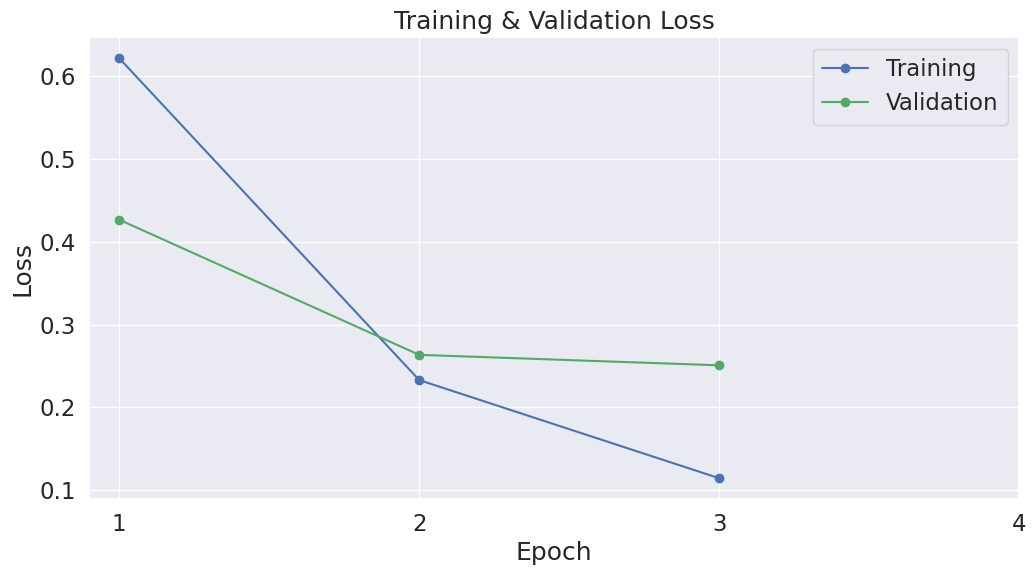

In [16]:
# Plot the Training & Validation Loss
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [17]:
# Save our model
# 1. Directory
OUTPUT_DIR = './models/'
if not os.path.exists(OUTPUT_DIR):
  os.makedirs(OUTPUT_DIR)

# 2. Create model save path
MODEL_NAME = "model.pth"
MODEL_SAVE_PATH = OUTPUT_DIR + MODEL_NAME

# 3. Save model state dict
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)